# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * scipy.randn(),
            'ss2': 2 + 10 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-28 17:21:57.513020, end_time=None)>
INFO:Epsilon:initial epsilon is 7.89338512219833
INFO:ABC:t:0 eps:7.89338512219833
INFO:ABC:t:1 eps:4.377862071693907
INFO:ABC:t:2 eps:2.6376915370204697
INFO:ABC:t:3 eps:1.780636833501515
INFO:ABC:t:4 eps:1.1339387760957091
INFO:ABC:t:5 eps:0.7800550237013555
INFO:ABC:t:6 eps:0.5701539748765928
INFO:ABC:t:7 eps:0.3751456569648852
INFO:History:Done <ABCSMC(id=1, start_time=2019-09-28 17:21:57.513020, end_time=2019-09-28 17:22:18.717462)>


Let us visualize the results for the non-adaptive distance:

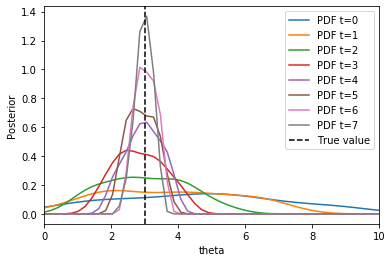

In [3]:
# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-28 17:22:19.132468, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 1.5130467630111348, 'ss2': 0.4869532369888651}
INFO:Epsilon:initial epsilon is 6.306197924275744
INFO:ABC:t:0 eps:6.306197924275744
DEBUG:Distance:updated weights[1] = {'ss1': 1.5186265226721591, 'ss2': 0.4813734773278407}
INFO:ABC:t:1 eps:3.8520808802032738
DEBUG:Distance:updated weights[2] = {'ss1': 1.6527198373788976, 'ss2': 0.3472801626211025}
INFO:ABC:t:2 eps:2.3116413538457183
DEBUG:Distance:updated weights[3] = {'ss1': 1.7691628245720286, 'ss2': 0.23083717542797133}
INFO:ABC:t:3 eps:1.3914368856178527
DEBUG:Distance:updated weights[4] = {'ss1': 1.8644142815660365, 'ss2': 0.13558571843396336}
INFO:ABC:t:4 eps:0.7051555229727929
DEBUG:Distance:updated weights[5] = {'ss1': 1.9127501934715825, 'ss2': 0.08724980652841752}
INFO:ABC:t:5 eps:0.433163266194128
DEBUG:Distance:updated weights[6] = {'ss1': 1.9559960068628204, 'ss2': 0.04400399313717975}
INFO:AB

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``pyabc.acceptor.accept_use_complete_history`` instead of the default ``pyabc.acceptor.accept_use_current_time`` in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

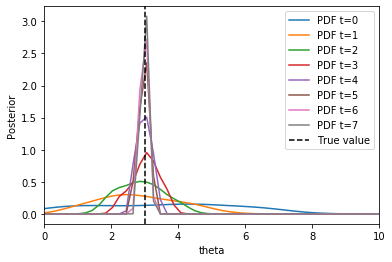

In [5]:
plot(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite, the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

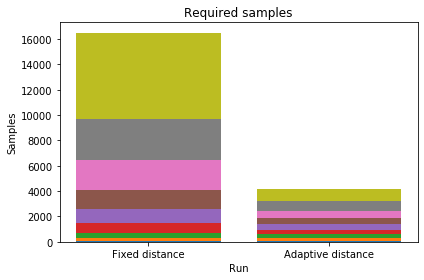

In [6]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. E.g., there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [7]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

INFO:History:Start <ABCSMC(id=3, start_time=2019-09-28 17:22:26.714429, end_time=None)>
INFO:Epsilon:initial epsilon is 4.227200289023806
INFO:ABC:t:0 eps:4.227200289023806
INFO:ABC:t:1 eps:3.2906895858729692
INFO:ABC:t:2 eps:3.071903896011634
INFO:ABC:t:3 eps:3.0236462574279988
INFO:ABC:t:4 eps:3.0053544309803133
INFO:ABC:t:5 eps:2.99841283007867
INFO:ABC:t:6 eps:2.992368262577131
INFO:ABC:t:7 eps:2.987369801231256
INFO:History:Done <ABCSMC(id=3, start_time=2019-09-28 17:22:26.714429, end_time=2019-09-28 17:22:56.049108)>


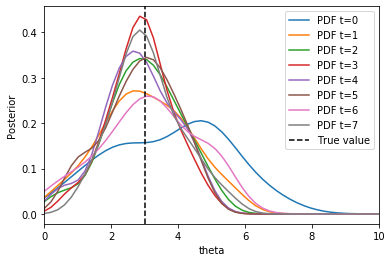

In [8]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history0)

INFO:History:Start <ABCSMC(id=4, start_time=2019-09-28 17:22:56.500054, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.005966548121614296, 'ss2': 1.9940334518783855}
INFO:Epsilon:initial epsilon is 5.9808987549370345
INFO:ABC:t:0 eps:5.9808987549370345
DEBUG:Distance:updated weights[1] = {'ss1': 0.006542846940525526, 'ss2': 1.9934571530594742}
INFO:ABC:t:1 eps:5.965950897844988
DEBUG:Distance:updated weights[2] = {'ss1': 0.00764552103913193, 'ss2': 1.992354478960868}
INFO:ABC:t:2 eps:5.9515188209968475
DEBUG:Distance:updated weights[3] = {'ss1': 0.00710958633590338, 'ss2': 1.9928904136640968}
INFO:ABC:t:3 eps:5.946990459691311
DEBUG:Distance:updated weights[4] = {'ss1': 0.006905063331719629, 'ss2': 1.9930949366682804}
INFO:ABC:t:4 eps:5.940801574523239
DEBUG:Distance:updated weights[5] = {'ss1': 0.006974629878516284, 'ss2': 1.9930253701214837}
INFO:ABC:t:5 eps:5.934462406738105
DEBUG:Distance:updated weights[6] = {'ss1': 0.007171069594913535, 'ss2': 1.9928289304050864}
I

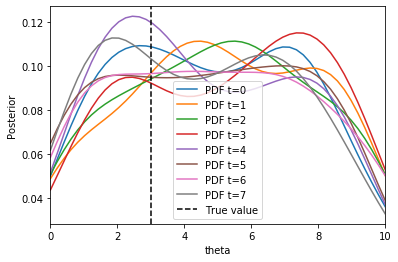

In [9]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history1)

These results are as expeted: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take te bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

INFO:History:Start <ABCSMC(id=6, start_time=2019-09-28 17:24:38.351836, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.9633630249405283, 'ss2': 1.0366369750594717}
INFO:Epsilon:initial epsilon is 3.8586910274463437
INFO:ABC:t:0 eps:3.8586910274463437
DEBUG:Distance:updated weights[1] = {'ss1': 0.9210388746249705, 'ss2': 1.0789611253750295}
INFO:ABC:t:1 eps:3.418735539854079
DEBUG:Distance:updated weights[2] = {'ss1': 1.2312641379957303, 'ss2': 0.7687358620042696}
INFO:ABC:t:2 eps:2.4365455215926715
DEBUG:Distance:updated weights[3] = {'ss1': 1.3023719819648805, 'ss2': 0.6976280180351196}
INFO:ABC:t:3 eps:2.1246101161486988
DEBUG:Distance:updated weights[4] = {'ss1': 1.306616576720619, 'ss2': 0.693383423279381}
INFO:ABC:t:4 eps:2.086268512814945
DEBUG:Distance:updated weights[5] = {'ss1': 1.339146364163825, 'ss2': 0.660853635836175}
INFO:ABC:t:5 eps:1.9823003919338895
DEBUG:Distance:updated weights[6] = {'ss1': 1.3531494351422888, 'ss2': 0.6468505648577113}
INFO:ABC:t:6 e

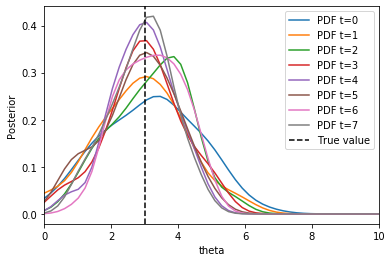

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history2)

The accuracy is back to the non-weighted case. In addition, slightly smaller weights are assigned to the second summary statistic, corresponding to a slight decrease in the total number of samples, as the following plot shows. Applying this method the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

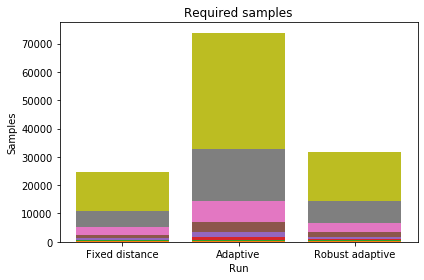

In [11]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Take information content into account

There is still one problem with the shown methods: What if in the second model we do not introduce a model error, but just decrease the relative variance of the second summary statistic? In this case, one could expect that all of the above adaptive methods assign high weights to `ss1`, although this statistic is obviously not informative of the parameters. So our final goal is to not only take variance of the simulations or bias to the data into account, but explicitly account for the information content of the summary statistics w.r.t. the parameters.

A toy model would be:

In [12]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()